In [1]:
import sys


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from cnn.dataset import V2Dataset
from cnn.hands_cnn import Hands_VGG16
from cnn.face_cnn import Face_CNN
from cnn.raw_cnn import Raw_CNN

from wrappers.hands_wrapper import Hands_Inference_Wrapper
from wrappers.face_wrapper import Face_Inference_Wrapper


BATCH_SZ=64

def per_class_accuracies(model, data_dir='data/v2_cam1_cam2_split_by_driver', detector=True, batch_size=BATCH_SZ):

    if detector:
        transform = v2.Compose([
        v2.Resize((640,640)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ])
    else:
        transform = v2.Compose([
        v2.Resize((224,224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        ])

    test_dataset = V2Dataset(cam1_path=f'{data_dir}/Camera 1/test', cam2_path=f'{data_dir}/Camera 2/test', transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    class_labels = list(test_dataset.classes)
    class_dict = test_dataset.classes_dict

    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    
    cm = confusion_matrix(all_labels, all_predictions)
    class_accs = cm.diagonal() / cm.sum(axis=1)


    for (key, value), acc in zip(class_dict.items(), class_accs):
        print(f'Class {value} -- "{key}" --: Accuracy = {acc:.2%}')
    
    return cm, class_labels



Check per class accuracy and confusion matrix for Hands Classifier

New https://pypi.org/project/ultralytics/8.0.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.208 🚀 Python-3.10.13 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16117MiB)
engine/trainer: task=detect, mode=train, model=/home/ron/Classes/CV-Systems/Project/cybertruck/detection/hands_detection/runs/detect/best/weights/best.pt, data=coco8.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_lab

Class c0 -- "Safe Driving" --: Accuracy = 17.34%
Class c1 -- "Text Right" --: Accuracy = 0.00%
Class c2 -- "Phone Right" --: Accuracy = 0.00%
Class c3 -- "Text Left" --: Accuracy = 0.00%
Class c4 -- "Phone Left" --: Accuracy = 18.24%
Class c5 -- "Adjusting Radio" --: Accuracy = 5.88%
Class c6 -- "Drinking" --: Accuracy = 9.79%
Class c7 -- "Reaching Behind" --: Accuracy = 56.64%
Class c8 -- "Hair or Makeup" --: Accuracy = 36.99%
Class c9 -- "Talking to Passenger" --: Accuracy = 28.90%


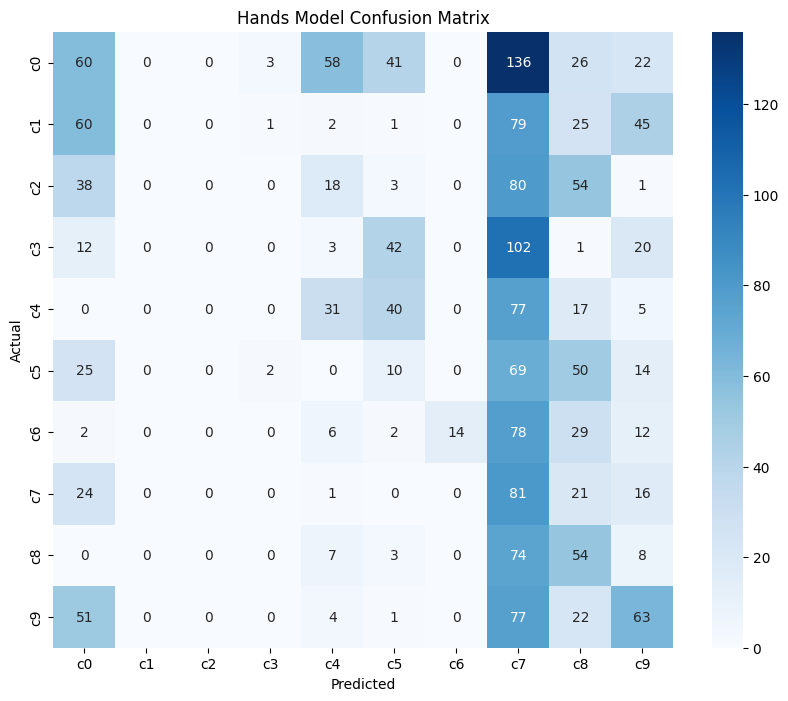

In [2]:
class HandArgs:
    def __init__(self):
        self.freeze = True
        self.num_frozen_params = 30
        self.dropout = 0.35

hand_args = HandArgs()


hands_model = Hands_VGG16(hand_args, num_classes=10).to('cuda')
hands_model.load_state_dict(torch.load('/home/ron/Classes/CV-Systems/Project/cybertruck/cnn/hands_models/vgg/hands_77ac.pt'))

hands_wrapper = Hands_Inference_Wrapper(hands_model, detector_path='/home/ron/Classes/CV-Systems/Project/cybertruck/detection/hands_detection/runs/detect/best/weights/best.pt')

hands_cm, class_labels = per_class_accuracies(hands_wrapper)


%matplotlib inline

plt.figure(figsize=(10, 8))
sns.heatmap(hands_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hands Model Confusion Matrix')
plt.show()

/home/ron/miniconda3/envs/cyber/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Class c0 -- "Safe Driving" --: Accuracy = 32.95%
Class c1 -- "Text Right" --: Accuracy = 51.64%
Class c2 -- "Phone Right" --: Accuracy = 55.15%
Class c3 -- "Text Left" --: Accuracy = 28.89%
Class c4 -- "Phone Left" --: Accuracy = 7.06%
Class c5 -- "Adjusting Radio" --: Accuracy = 15.88%
Class c6 -- "Drinking" --: Accuracy = 37.76%
Class c7 -- "Reaching Behind" --: Accuracy = 72.03%
Class c8 -- "Hair or Makeup" --: Accuracy = 82.19%
Class c9 -- "Talking to Passenger" --: Accuracy = 71.56%


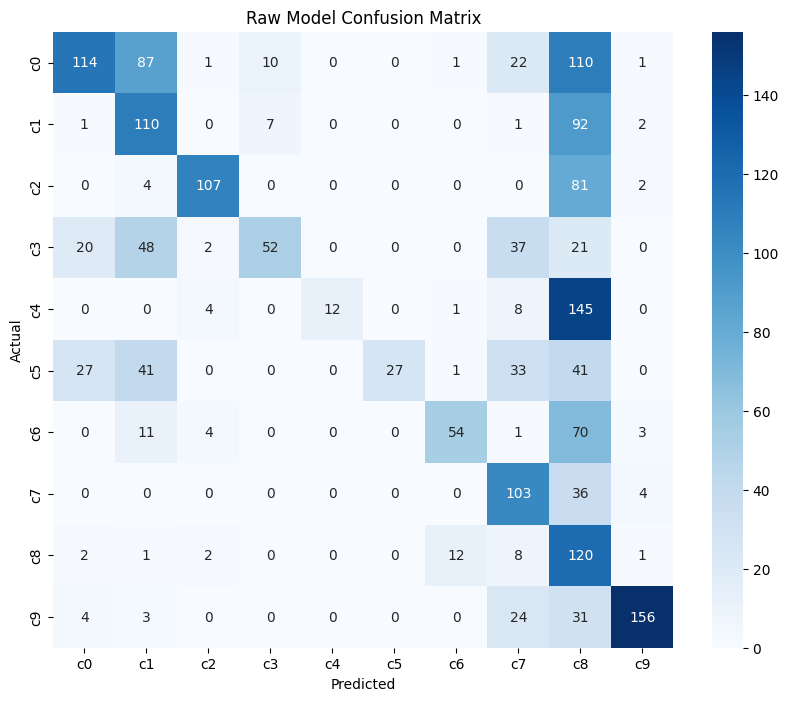

In [3]:
raw_model = Raw_CNN(None, num_classes=10).to('cuda')
raw_model.load_state_dict(torch.load('/home/ron/Classes/CV-Systems/Project/cybertruck/cnn/raw_models/raw/SGD/raw_76acc.pt'))


face_cm, face_clabels = per_class_accuracies(raw_model, detector=False)

%matplotlib inline

plt.figure(figsize=(10, 8))
sns.heatmap(face_cm, annot=True, fmt='d', cmap='Blues', xticklabels=face_clabels, yticklabels=face_clabels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Raw Model Confusion Matrix')
plt.show()

In [5]:
face_model = Face_CNN(hand_args, num_classes=10).to('cuda')
face_model.load_state_dict(torch.load('/home/ron/Classes/CV-Systems/Project/cybertruck/cnn/face_models/face/SGD/face_66acc.pt'))

face_wrapper = Face_Inference_Wrapper(face_model, detector_path='/home/ron/Classes/CV-Systems/Project/cybertruck/detection/face_detection/weights/yolov8n-face.pt')

/home/ron/miniconda3/envs/cyber/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


New https://pypi.org/project/ultralytics/8.0.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.208 🚀 Python-3.10.13 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16117MiB)
engine/trainer: task=detect, mode=train, model=/home/ron/Classes/CV-Systems/Project/cybertruck/detection/hands_detection/runs/detect/best/weights/best.pt, data=coco8.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_la

Class c0 -- "Safe Driving" --: Accuracy = 34.39%
Class c1 -- "Text Right" --: Accuracy = 48.36%
Class c2 -- "Phone Right" --: Accuracy = 52.06%
Class c3 -- "Text Left" --: Accuracy = 27.78%
Class c4 -- "Phone Left" --: Accuracy = 6.47%
Class c5 -- "Adjusting Radio" --: Accuracy = 15.29%
Class c6 -- "Drinking" --: Accuracy = 34.97%
Class c7 -- "Reaching Behind" --: Accuracy = 72.73%
Class c8 -- "Hair or Makeup" --: Accuracy = 88.36%
Class c9 -- "Talking to Passenger" --: Accuracy = 71.10%


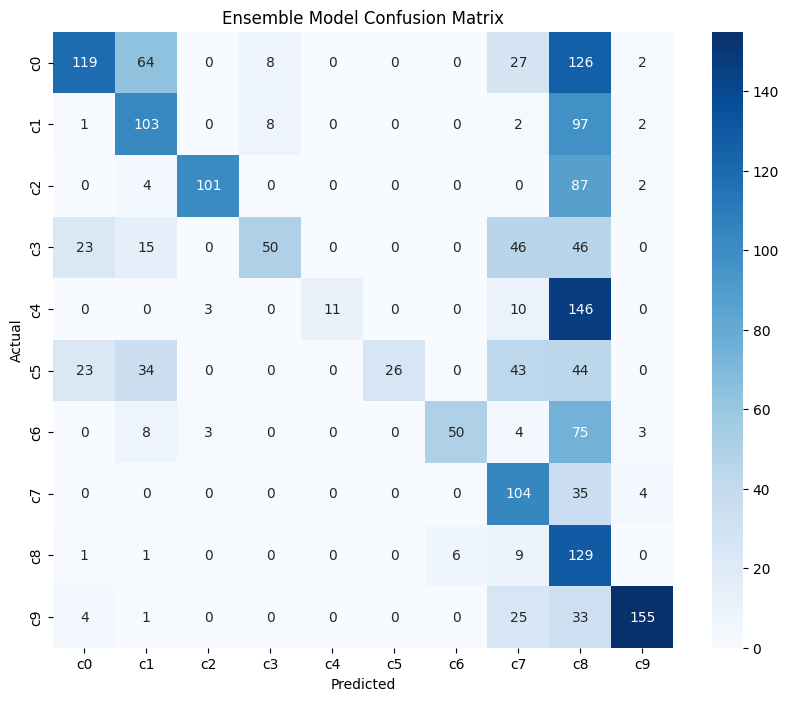

In [8]:
from ensemble import Ensemble

hand_args.device = 'cuda'

cnns = [hands_wrapper, face_wrapper, raw_model]
ensemble_model = Ensemble(hand_args, cnns, None, num_classes=10)

ensemble_cm, ensemble_clabels = per_class_accuracies(ensemble_model, detector=False)

%matplotlib inline

plt.figure(figsize=(10, 8))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues', xticklabels=ensemble_clabels, yticklabels=ensemble_clabels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Model Confusion Matrix')
plt.show()